https://towardsdatascience.com/classifying-adhd-from-healthy-controls-using-lstms-with-rs-fmri-data-300c1f3e9697

Data Info
*   86 subjects
*   300 avg amygdala value per timepoint (each a second apart)
*   5470, 5900, 6102, 6674, 6739, 6804, 7515, 7715, 8181, 8882 timepoints in each movie type

## Using LSTM to analyze Naturaliztic Viewing Data

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

#sklearn - basic ML tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn import metrics

#keras - for NN models
from keras.models import Model, Sequential
import keras as tfk
from keras import optimizers
from keras.utils import plot_model
from keras import utils
tfkl = tfk.layers
from sklearn.metrics import roc_curve


#scipy- statistical analysis tools
from scipy.stats import ttest_1samp
from scipy import interp

In [ ]:
# mount google drive
from google.colab import drive
drive.mount("/content/gdrive/")
%cd "/content/gdrive/My Drive/LSTM_fMRI"

## Preparing data for analysis ##

Import data, and exctract features

In [ ]:
ldataT = pd.read_csv('lamygT_zscored_ts (1).csv', index_col='Unnamed: 0')
rdataT = pd.read_csv('ramygT_zscored_ts (1).csv',index_col='Unnamed: 0')
emolables = pd.read_csv('demographics_table.csv',index_col='Bids_number')

In [ ]:
emolables["Ethnicity"].value_counts(dropna=False)

White                               43
Asian                               24
Black or African American           10
Other                                6
NaN                                  2
Black or African American, White     1
Name: Ethnicity, dtype: int64

In [ ]:
emolables["Gender"].value_counts(dropna=False)

M    44
F    42
Name: Gender, dtype: int64

In [ ]:
# Calculate the mean amygdala response for each participant
lmeans = ldataT.mean(axis=1)
rmeans = rdataT.mean(axis=1)

### Calculate where the split should be made
based on the figure the splits should be:
> low < 43 <br>
> medium 43 - 57 <br>
> high > 57

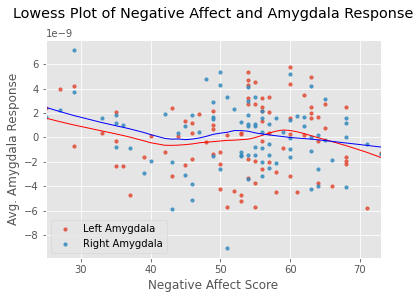

In [ ]:
ax = sns.regplot(emolables['Negative_Affect_Summary_over_18'], lmeans, label="Left Amygdala", scatter_kws={"s":10},
            line_kws={"color":"r","alpha":1,"lw":1}, lowess=True)
ax = sns.regplot(emolables['Negative_Affect_Summary_over_18'], rmeans, label="Right Amygdala", scatter_kws={"s":10},
            line_kws={"color":"b","alpha":1,"lw":1}, lowess=True)
plt.xlabel("Negative Affect Score")
plt.ylabel("Avg. Amygdala Response")
plt.title("Lowess Plot of Negative Affect and Amygdala Response\n")
ax.legend(loc='best')
plt.show()

In [ ]:
# make split
emolables["Groups"] = ""
emolables.loc[(emolables.Negative_Affect_Summary_over_18 <= 45),"Groups"] = 0
emolables.loc[((emolables.Negative_Affect_Summary_over_18 > 45) & (emolables.Negative_Affect_Summary_over_18 < 57)),"Groups"] = 1
emolables.loc[(emolables.Negative_Affect_Summary_over_18 >= 57),"Groups"] = 2
emolables["Groups"].value_counts(dropna=False)

1    37
2    31
0    18
Name: Groups, dtype: int64

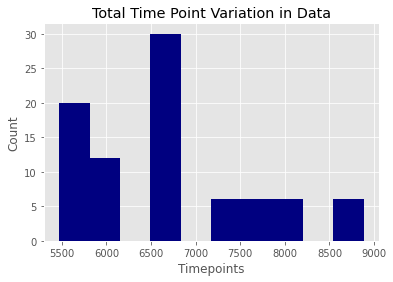

In [ ]:
plt.hist(ldataT.count(axis=1).tolist(),color='navy')
plt.title('Total Time Point Variation in Data')
plt.xlabel('Timepoints')
plt.ylabel('Count')
plt.show()

In [ ]:
set(ldataT.count(axis=1).tolist())


{5470, 5900, 6102, 6674, 6739, 6804, 7515, 7715, 8181, 8882}

In [ ]:
l = ldataT.index.tolist()
l2 = {}
for row in l:
    temp = row.split('-')
    l2[row] = int(temp[1])
l2 = sorted(l, key=lambda row: l2[row])
ldataT.reindex(l2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,8842,8843,8844,8845,8846,8847,8848,8849,8850,8851,8852,8853,8854,8855,8856,8857,8858,8859,8860,8861,8862,8863,8864,8865,8866,8867,8868,8869,8870,8871,8872,8873,8874,8875,8876,8877,8878,8879,8880,8881
sub-1,-3.414195,-1.980726,-0.173855,3.414067,1.359372,-0.711514,-2.317778,2.174815,-0.999177,3.062898,1.006448,2.689139,-0.475417,0.357086,-0.547013,0.404187,-1.290902,0.763931,-1.435731,0.519451,-0.476227,0.540152,1.261702,-2.838285,-2.206195,-2.345144,1.945188,-1.044283,3.228976,0.793788,-0.531289,-1.140516,1.064271,2.923445,1.284990,2.360588,0.552649,-1.394482,1.411757,-5.382966,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub-2,0.104302,-1.028803,-2.397205,0.909122,-1.353000,1.187146,0.641111,0.896236,0.613070,1.087422,1.098470,0.724351,1.180992,-0.961607,0.339138,0.187881,-0.077784,0.855486,0.700535,0.384290,-0.314546,-0.112272,-0.010183,-2.260475,1.370115,-1.174138,-0.922265,-2.150201,-2.684265,-0.677078,1.193941,0.146227,0.281776,-1.019723,-0.709710,2.277112,0.769846,1.522972,0.173003,1.304655,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub-3,0.336800,-0.021290,-1.979479,-0.325970,-0.686092,-0.053824,3.032096,0.136250,0.783180,-0.716249,-0.068060,0.048692,-0.771241,0.393571,0.412747,0.885654,-0.945599,-0.200658,0.975744,0.957764,0.087688,0.348674,0.207678,1.702082,0.548416,-2.106466,-0.248305,-0.596674,-0.735401,0.583322,0.816075,-0.251529,-1.686390,-1.816614,-1.875483,0.239022,-1.207223,-1.257109,0.421646,0.094832,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub-4,-1.359091,0.713983,-1.119302,0.583545,-0.105390,1.208912,1.344289,0.173698,-0.024862,-0.615519,0.097532,0.512631,-1.321575,-1.096580,-2.172842,-0.941211,0.231664,-0.332001,-0.089742,0.726613,0.735560,0.597256,1.214270,1.777098,2.057221,-0.296762,0.446328,-0.054203,-0.779258,-1.298105,-0.975565,-0.910251,0.882082,-0.235876,0.882936,1.086668,0.891979,1.810429,0.832933,0.262112,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub-5,-0.007504,0.038567,-1.037762,0.464053,0.173443,-0.758623,-0.077658,0.403739,0.035794,0.568489,-0.525036,1.029468,0.264747,0.527313,-0.640556,0.545523,0.193328,-0.422215,-0.289784,0.216962,1.115279,1.303470,0.170747,-1.865201,0.029764,-0.211839,-0.505318,0.121381,-0.491504,0.643900,2.056901,-0.587365,-0.452419,-0.795823,0.927242,0.865616,0.254696,-0.899266,-2.003207,-0.599955,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-82,-0.088424,-0.102934,-0.297333,0.355277,-0.719425,0.100274,1.081798,-1.482936,0.232276,-0.392782,0.712639,-0.529224,0.146819,-0.243874,-0.586428,-1.695448,-0.883914,-0.135905,0.320067,1.317115,2.190762,1.309470,1.278511,0.870732,-0.706499,-0.098930,1.141664,0.929437,-0.289866,1.136457,-0.302626,0.077733,-0.475454,0.582779,1.306357,0.079653,-0.388895,-0.402140,-0.060000,0.367676,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub-83,0.263538,-0.636582,0.428314,-0.323350,-0.757630,0.208443,1

In [ ]:
r = rdataT.index.tolist()
r2 = {}
for row in r:
    temp = row.split('-')
    r2[row] = int(temp[1])
r2 = sorted(r, key=lambda row: r2[row])
rdataT.reindex(r2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,8842,8843,8844,8845,8846,8847,8848,8849,8850,8851,8852,8853,8854,8855,8856,8857,8858,8859,8860,8861,8862,8863,8864,8865,8866,8867,8868,8869,8870,8871,8872,8873,8874,8875,8876,8877,8878,8879,8880,8881
sub-1,2.675195,-1.534641,0.273193,-2.443353,-1.787369,3.705651,-1.224764,1.419781,0.770952,1.166528,-0.439234,-0.213798,0.449913,-1.234938,0.536177,-2.404326,0.017511,2.216110,0.549834,1.149065,-0.343216,-1.021507,-0.562758,-1.933353,-0.517664,-1.046003,0.866843,-0.868654,-0.553648,-2.732110,1.973047,1.226177,-1.598410,1.153614,0.844225,0.428751,1.671632,-1.018135,-1.060159,-3.815040,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub-2,-0.451512,0.330516,-0.267524,-0.069652,1.025645,0.840864,0.677744,0.796774,-1.089442,0.694220,-0.241246,1.300530,-0.122482,0.854396,-1.081048,-0.978203,-0.324393,-1.162155,-0.067253,0.659966,-1.157288,-0.722111,1.904035,-0.332371,-1.459896,-0.038082,-0.896458,-0.894949,0.541030,2.276531,-1.015492,-1.172782,-1.998789,-0.437922,0.534616,-0.910679,0.547847,-1.766426,-0.096990,1.390561,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub-3,0.746481,0.195691,-0.907646,0.038920,-0.768226,0.625811,-0.130508,1.315112,-0.219741,-0.468658,-0.087119,-0.166935,0.952606,1.081453,0.090441,0.273610,-0.829480,0.299764,-1.426205,0.009622,0.148627,-0.436374,-0.327323,-0.058623,-0.350105,-0.327055,-0.896848,0.055315,0.896410,0.639025,-1.121692,-0.639631,-1.370132,-1.640744,-0.533579,0.983210,-0.546685,-0.194284,-0.239083,0.949266,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub-4,0.247209,-0.006251,-0.108443,-1.264034,-1.015870,0.288687,0.347748,0.487118,1.218235,1.416875,0.769924,0.101319,0.421685,-0.378259,-1.428684,-1.833253,-0.370861,-0.809935,1.011843,0.316395,-0.958532,1.357094,0.041331,1.183374,1.028306,-0.111674,-0.043528,1.212334,-0.003019,-1.309757,-0.923118,-1.920839,1.166971,0.201771,-1.099787,-1.444055,-0.494241,0.351917,0.233352,-0.141635,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub-5,-0.925223,0.341460,1.654739,-1.062825,-0.353214,-0.178105,0.770243,-1.099428,0.020998,-0.264664,0.730426,-0.503918,0.675682,0.542522,1.051697,0.036541,-0.869908,-1.189997,0.553577,0.313201,-0.311102,0.678660,-0.528561,0.082770,2.535022,-1.465051,1.254516,0.454536,-0.196605,-0.300227,-0.866183,-0.182083,-1.077767,0.619330,0.056278,1.391447,-0.678884,-1.483524,-0.643681,-1.275222,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-82,0.192897,0.072305,-1.047811,-0.309519,-0.474592,0.401857,1.705003,1.545734,-1.954441,-0.269559,-0.034687,-0.573763,0.028031,-0.906159,1.218432,-0.811551,1.034585,0.269802,-0.218312,0.175994,1.052573,0.913419,0.558259,0.272238,-0.157717,-0.570601,-0.262917,0.321979,-1.227789,0.262561,-0.589924,0.403076,-0.094151,-0.981480,1.862289,0.010742,-0.702466,0.812766,-1.026954,-0.757720,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub-83,0.055404,1.546799,-0.606684,-0.722603,0

In [ ]:
#amydata = pd.concat([ldataT,rdataT])
#data = amydata.join(emolables['Groups'])
#features = data.drop(columns=['Groups'])
labels = emolables['Groups']

In [ ]:
maxlen = 60 # make the taining data 5 minutes of scanning
x = []
y=[]
for label, row in zip(labels, range(0, len(ldataT))):
  lcleanedList = [x for x in ldataT.iloc[1] if np.isnan(x)==False]
  rcleanedList = [x for x in ldataT.iloc[1] if np.isnan(x)==False]  
  for col in range(0,(len(lcleanedList)+1)-maxlen,maxlen):
    x.append([lcleanedList[col:col+maxlen],rcleanedList[col:col+maxlen]])
    y.append(label)

In [ ]:
print(np.array(y).shape)
x = np.array(x).swapaxes(1, 2)
# 2494 samples
# 300 time steps per sample
# 2 features per time step
print(np.array(x).shape)

(7826,)
(7826, 60, 2)


In [ ]:
def get_train_test(x, y, verbrose=False):
  '''
  split to train and test and reshape data
  X data
  y labels
  '''
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, 
                                                      random_state=4, stratify=y)
  # Reshapes data to 4D for Hierarchical RNN.
  t_shape=np.array(x).shape[1]
  RSN_shape=np.array(x).shape[2]
  
  x_train = np.reshape(x_train, (len(x_train), t_shape, RSN_shape))
  x_test = np.reshape(x_test, (len(x_test), t_shape, RSN_shape))

  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')

  if verbrose:
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
  
  # Converts class vectors to binary class matrices.
  y_train = utils.to_categorical(y_train, 3)
  y_test = utils.to_categorical(y_test, 3)
  
  return x_train, x_test, y_train, y_test
### maybe we input the incorrect ones that have NaNs
### maybe exploding gradients

In [ ]:
x_train, x_test, y_train, y_test = get_train_test(x, y, verbrose=True)

6260 train samples
1566 test samples


In [ ]:
print(np.array(y_train).shape)
print(np.array(x_train).shape)

(6260, 3)
(6260, 60, 2)


## Build the LSTM model

In [ ]:
model = Sequential()

# LSTM layers - 
# Long Short-Term Memory layer - Hochreiter 1997.
t_shape=np.array(x).shape[1]
RSN_shape=np.array(x).shape[2]

model.add(tfkl.LSTM(units=128, # dimensionality of the output space 
               dropout=0.2, # Fraction of the units to drop (inputs)
               recurrent_dropout=0.15, 
               return_sequences=False, # return the last state in addition to the output
               input_shape=(t_shape,RSN_shape)))

model.add(tfkl.Dense(3, activation='softmax'))

model.compile(
    optimizer=tfk.optimizers.RMSprop(lr=0.01),  # Optimizer
    # Loss function to minimize
    loss=tfk.losses.CategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[tfk.metrics.CategoricalAccuracy()],
)

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               67072     
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 67,459
Trainable params: 67,459
Non-trainable params: 0
_________________________________________________________________
None


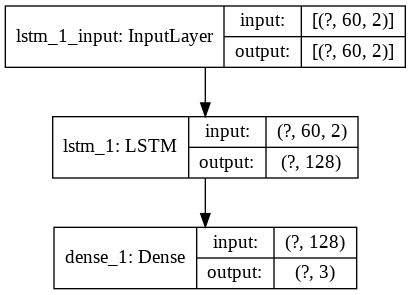

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

## Train the LSTM model

In [ ]:
results = model.fit(x_train, y_train, epochs=20, batch_size=100,
                    validation_split=0.2)
#print(history.results['loss'])
#print(history.results['accuracy'])

Epoch 1/20
51/51 [==============================] - 10s 198ms/step - loss: 1.0753 - categorical_accuracy: 0.4147 - val_loss: 1.1464 - val_categorical_accuracy: 0.4177
Epoch 2/20
51/51 [==============================] - 10s 198ms/step - loss: 1.0573 - categorical_accuracy: 0.4297 - val_loss: 1.3473 - val_categorical_accuracy: 0.4177
Epoch 3/20
51/51 [==============================] - 10s 201ms/step - loss: 1.0617 - categorical_accuracy: 0.4317 - val_loss: 1.0851 - val_categorical_accuracy: 0.4177
Epoch 4/20
51/51 [==============================] - 10s 200ms/step - loss: 1.0589 - categorical_accuracy: 0.4321 - val_loss: 1.0877 - val_categorical_accuracy: 0.3650
Epoch 5/20
51/51 [==============================] - 10s 202ms/step - loss: 1.0590 - categorical_accuracy: 0.4271 - val_loss: 1.0712 - val_categorical_accuracy: 0.4177
Epoch 6/20
51/51 [==============================] - 11s 212ms/step - loss: 1.0574 - categorical_accuracy: 0.4329 - val_loss: 1.0697 - val_categorical_accuracy: 0.417

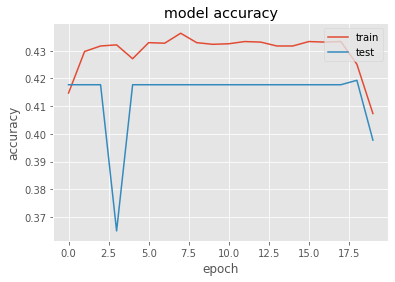

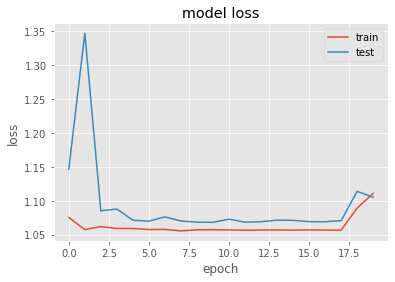

In [ ]:
# summarize history for accuracy
plt.plot(results.history['categorical_accuracy'])
plt.plot(results.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Evaluate the LSTM model

In [ ]:
from sklearn.metrics import accuracy_score

def boostrapping_hypothesis_testing(x_train, y_train, x_test, y_test,
                                    n_iterations=25, n_epochs=20):

  '''
  hypothesis testing function
  X_train, y_train, X_test, y_test- the data
  n_iterations- number of bootdtaping iterations 
  n_epochs - number of epochs for model's training
  '''

  accuracy=[] ## model accuracy
  roc_msrmnts_fpr=[] ## false positive rate
  roc_msrmnts_tpr=[] ## true positive rate

  # run bootstrap
  for i in range(n_iterations):
    # prepare train and test sets
    x_train, x_test, y_train, y_test=get_train_test(x, y, verbrose=False)
    # fit model
    print('fitting..')
    model.fit(x_train, y_train, validation_split=0.2, epochs=n_epochs)
    
    # evaluate model
    print('evaluating..')
    y_pred=model.predict(x_test)
    y_test_1d=[i[0] for i in y_test]
    y_pred_1d=[1.0 if i[0]>.5 else 0.0 for i in y_pred]

    fpr, tpr, _ = roc_curve(y_test_1d, y_pred_1d)
    
    acc_score = accuracy_score(y_test_1d, y_pred_1d)
    
    accuracy.append(acc_score)
    roc_msrmnts_fpr.append(fpr)
    roc_msrmnts_tpr.append(tpr)

  return accuracy, roc_msrmnts_fpr, roc_msrmnts_tpr 



accuracy, roc_msrmnts_fpr, roc_msrmnts_tpr  = boostrapping_hypothesis_testing(x_train, y_train, x_test, y_test)

fitting..
Epoch 1/20
157/157 [==============================] - 21s 131ms/step - loss: 1.1079 - categorical_accuracy: 0.4151 - val_loss: 1.1436 - val_categorical_accuracy: 0.3866
Epoch 2/20
157/157 [==============================] - 21s 133ms/step - loss: 1.1112 - categorical_accuracy: 0.4044 - val_loss: 1.1948 - val_categorical_accuracy: 0.3610
Epoch 3/20
157/157 [==============================] - 21s 133ms/step - loss: 1.1010 - categorical_accuracy: 0.4111 - val_loss: 1.0866 - val_categorical_accuracy: 0.4177
Epoch 4/20
157/157 [==============================] - 20s 130ms/step - loss: 1.0663 - categorical_accuracy: 0.4251 - val_loss: 1.0713 - val_categorical_accuracy: 0.4177
Epoch 5/20
157/157 [==============================] - 21s 135ms/step - loss: 1.0584 - categorical_accuracy: 0.4309 - val_loss: 1.0774 - val_categorical_accuracy: 0.4177
Epoch 6/20
157/157 [==============================] - 21s 137ms/step - loss: 1.0583 - categorical_accuracy: 0.4317 - val_loss: 1.0700 - val_categ

In [ ]:
def calc_p_val(stats, h0, n_iterations):
  '''
  finds the p value for the results 
  
  '''
  # calc pval
  tset, pval = ttest_1samp(stats, h0)

  return pval

p_val=calc_p_val(accuracy, .33, 25)

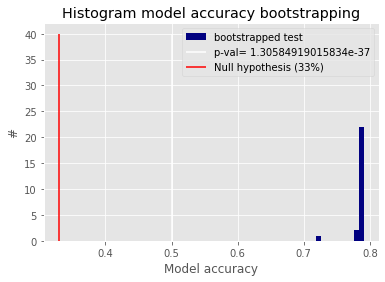

In [ ]:
def plot_p_value(stats, p_val):
  '''
  plots the bootstrapping results with the null hypothesis value
  '''
  
  plt.hist(stats, label='bootstrapped test',color='navy')
  plt.vlines(.5, 0, 40, color='white', label='p-val= {}'.format(p_val))
  plt.vlines(.33, 0, 40, color='red', label='Null hypothesis (33%)')

  plt.title('Histogram model accuracy bootstrapping')
  plt.xlabel('Model accuracy')
  plt.ylabel('#')
  plt.legend()
  plt.plot()

plot_p_value(accuracy, p_val)

## Next Steps
1. Video clips with single emoiton - label emotion
2. Video clips with differnt people expressing the same emotion - label person
3. Video clips of emotion transitions - label transition